Notebook for elaboration of grid frames and comparison of C results among optimizations. First we may want to import the libraries for data manipulation.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import math

# Imports for the implementation of the gif
import ffmpeg
import matplotlib.pyplot as plt
import matplotlib.animation as animation

And define the C results paths.

In [2]:
BASE_RESULTS = '../hpc/results/'

Let's now get the files inside the base folder and list them

In [3]:
files = os.listdir(BASE_RESULTS)
print(files)

['simulation_0_1.json', 'simulation_2_3.json', 'simulation_4_1.json', '.gitkeep', 'simulation_3_1.json', 'simulation_5_1.json', 'simulation_1_2.json']


Remove .gitkeep file

In [4]:
files.remove('.gitkeep')

print(files)

['simulation_0_1.json', 'simulation_2_3.json', 'simulation_4_1.json', 'simulation_3_1.json', 'simulation_5_1.json', 'simulation_1_2.json']


Amount of simulations that were performed:

In [5]:
len(files)

6

For the moment we're considering only the first simulation

In [6]:
sim = str(BASE_RESULTS + files[1])
file = json.load(open(sim))

print(sim)

meta = file['metadata']

../hpc/results/simulation_2_3.json


Metadata structure:

In [7]:
print(json.dumps(meta, indent=2))

{
  "time_step": 0.01,
  "ticks": 100,
  "world": {
    "width": 80,
    "height": 120,
    "width_bounds": 82,
    "height_bounds": 122
  },
  "fluid": {
    "viscosity": 0.001,
    "density": 10,
    "diffusion": 0.001
  }
}


Let's now get some info from the metadata

In [8]:
TICKS = meta['ticks']
FRAMES = TICKS + 1
WIDTH_BOUNDS = meta['world']['width_bounds']
HEIGHT_BOUNDS = meta['world']['height_bounds']
FRAME_POINTS = WIDTH_BOUNDS * HEIGHT_BOUNDS

if (FRAMES) != len(file['snapshots']):
    raise ValueError("Exception - the amount of snapshots is not equal to the amount of ticks +1 reported in the metadata.")
for i in range(FRAMES):
    if FRAME_POINTS != len(file['snapshots'][i]):
        raise ValueError(f"Exception - the amount of frames in snapshot #{i} is not equal to the one obtained from the metadata.")

print("Ticks: ", TICKS)
print("Snapshots: ", FRAMES)
print("Frame for each snapshot:", FRAME_POINTS)
print("Width bounds: ", WIDTH_BOUNDS)
print("Height bounds: ", HEIGHT_BOUNDS)

Ticks:  100
Snapshots:  101
Frame for each snapshot: 10004
Width bounds:  82
Height bounds:  122


Now let's take a look at our snapshots in JSON format:

In [9]:
print(json.dumps(file['snapshots'][2][:4], indent=2))

[
  {
    "x": 0,
    "y": 0,
    "d": 1.442523499179223e-20,
    "u": 0,
    "v": 0
  },
  {
    "x": 1,
    "y": 0,
    "d": 1.442523499179223e-20,
    "u": 0.005870903735493026,
    "v": -0.00091361352700491
  },
  {
    "x": 2,
    "y": 0,
    "d": 1.6412166889419313e-19,
    "u": 0.015896789799338673,
    "v": -0.00090970097021713
  },
  {
    "x": 3,
    "y": 0,
    "d": 1.9766896704143047e-18,
    "u": 0.02512265619272861,
    "v": -0.000880618467986927
  }
]


Now let's extract our data and save it in a list of DataFrames, where each DataFrame will correspond to a snapshot at a certain time step of the simulation.

In [10]:
data = []
for i in range(FRAMES):
    data.append(pd.DataFrame(file["snapshots"][i]))

And check the structure of a single frame with x and y positions of the cell, d as density, u as force along the x dimension and v as force along the y.

In [11]:
data[45].head()

,x,y,d,u,v
0,0,0,4.576422e-09,0.000000,0.000000
1,1,0,4.576422e-09,0.012212,0.006930
2,2,0,1.164431e-08,0.034052,0.007084
3,3,0,3.606265e-08,0.054949,0.007382
4,4,0,1.113523e-07,0.076992,0.007831


Let's now pre-process the data in order to normalize values up to 255 to be used in the graphic visualization phase.

In [12]:
plot_data = []

for i in range(len(data)):
    for idx, x in enumerate(data[i].d):
        
        tmp = np.int32(x*255)
        if tmp>=255:
            tmp = 255

        data[i].at[idx, 'd'] = tmp

for i in range(FRAMES):
    frame = {"x": data[i].x[:FRAME_POINTS], "y": data[i].y[:FRAME_POINTS], "density": data[i].d[:FRAME_POINTS]}
    plot_data.append(frame)

And now move to the gif generation.

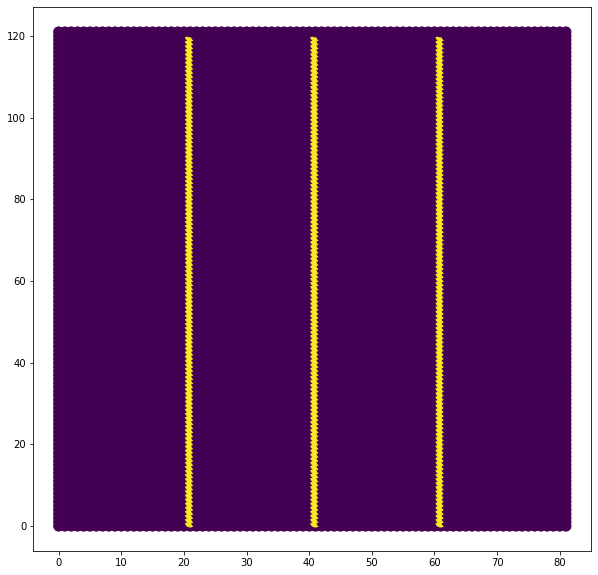

In [13]:
def main():
    color_data = plot_data[0]['density']  #np.random.random((FRAMES, FRAME_POINTS))  # THIS INSTEAD DOES SOMETHING SIMILAR
    x, y, c = plot_data[0]['x'], plot_data[0]['y'], plot_data[0]['density']

    fig = plt.figure(figsize=(10, 10))
    scat = plt.scatter(x, y, c=c, s=100)

    ani = animation.FuncAnimation(fig, update_plot, frames=range(FRAMES),
                                  fargs=(color_data, scat))
    plt.show()
    ani.save('./gifs/animation.gif')

def update_plot(i, custom_data, scat):
    scat.set_offsets(np.c_[plot_data[i]['x'], plot_data[i]['y']])
    scat.set_array(plot_data[i]['density'])
    return scat,

main()